<a href="https://colab.research.google.com/github/nikbizkit/MMO/blob/main/LR3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Выполнил: Попов М.А. ИУ5-24М


In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import scipy.stats as stats
import six
import sys
from sklearn.impute import SimpleImputer
sys.modules['sklearn.externals.six'] = six
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')




In [23]:
data = pd.read_csv('football.csv')
data.head()


,competition,date,match,team,pos,pos_role,player,rater,is_human,original_rating,...,betweenness_centrality,closeness_centrality,flow_centrality,flow_success,betweenness2goals,win,lost,is_home_team,minutesPlayed,game_duration
0,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,Kicker,1,3.50,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90,90
1,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,WhoScored,0,6.56,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90,90
2,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,SofaScore,0,6.70,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90,90
3,Euro 2016,10/06/2016,"France - Romania, 2 - 1",France,Sub,Sub,Anthony Martial,WhoScored,0,6.19,...,0.051556,0.524845,0.041096,0.166667,0.0,1,0,1,13,90
4,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,MF,DMC,Mihai Pintilii,Kicker,1,3.50,...,0.333284,0.710084,0.347826,0.675075,0.0,0,1,0,90,90


Масштабирование признаков


In [24]:
data['original_rating'].describe()

count    50652.000000
mean         5.687847
std          1.673356
min          1.000000
25%          4.500000
50%          6.040000
75%          7.000000
max         10.000000
Name: original_rating, dtype: float64

In [25]:
minMaxScaler = MinMaxScaler()
data['original_rating_minmax'] = minMaxScaler.fit_transform(data[['original_rating']])
data['original_rating_minmax'].describe()

count    50652.000000
mean         0.520872
std          0.185928
min          0.000000
25%          0.388889
50%          0.560000
75%          0.666667
max          1.000000
Name: original_rating_minmax, dtype: float64

In [26]:
standardScaler = StandardScaler()
data['original_rating_standard'] = standardScaler.fit_transform(data[['original_rating']])
data['original_rating_standard'].describe()


count    5.065200e+04
mean    -1.231747e-15
std      1.000010e+00
min     -2.801492e+00
25%     -7.098662e-01
50%      2.104490e-01
75%      7.841520e-01
max      2.576974e+00
Name: original_rating_standard, dtype: float64

In [27]:
robustScaler = RobustScaler()
data['original_rating_robust'] = robustScaler.fit_transform(data[['original_rating']])
data['original_rating_robust'].describe()

count    50652.000000
mean        -0.140861
std          0.669343
min         -2.016000
25%         -0.616000
50%          0.000000
75%          0.384000
max          1.584000
Name: original_rating_robust, dtype: float64

Обработка выбросов

In [28]:
def diagnostic_plots(df, variable):
 fig, ax = plt.subplots(figsize=(20,10))
 plt.subplot(2, 2, 1)
 sns.kdeplot(data=data, x=variable)
 ## Q-Q plot
 plt.subplot(2, 2, 2)
 stats.probplot(df[variable], dist="norm", plot=plt)
 # ящик с усами
 plt.subplot(2, 2, 3)
 sns.boxplot(x=df[variable])
 # ящик с усами
 plt.subplot(2, 2, 4)
 df[variable].hist(bins=30)
 plt.show()


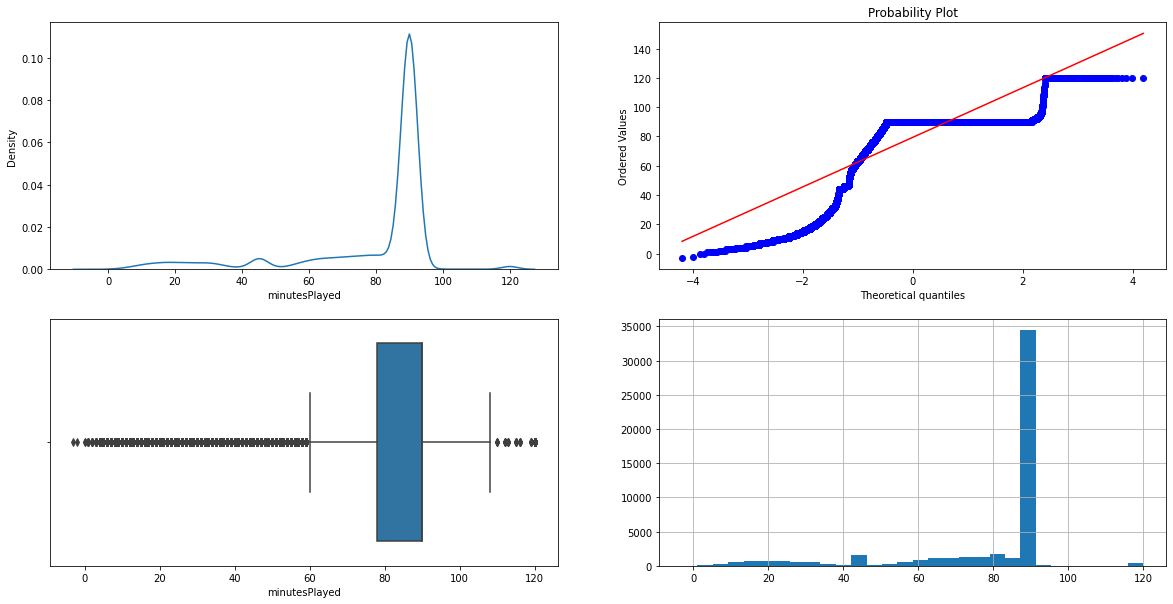

In [29]:
diagnostic_plots(data, 'minutesPlayed')


In [30]:
outlierBoundaryType = {
 'SIGMA': 1,
 'QUANTILE': 2,
 'IRQ': 3
}


In [31]:
def get_outlier_boundaries(df, col, outlier_boundary_type):
 if outlier_boundary_type == outlierBoundaryType['SIGMA']:
  K1 = 3
  lower_boundary = df[col].mean() - (K1 * df[col].std())
  upper_boundary = df[col].mean() + (K1 * df[col].std())
 elif outlier_boundary_type == outlierBoundaryType['QUANTILE']:
  lower_boundary = df[col].quantile(0.05)
  upper_boundary = df[col].quantile(0.95)
 elif outlier_boundary_type == outlierBoundaryType['IRQ']:
  K2 = 1.5
  IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
  lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
  upper_boundary = df[col].quantile(0.75) + (K2 * IQR)
 else:
  return 0, 0
 return lower_boundary, upper_boundary

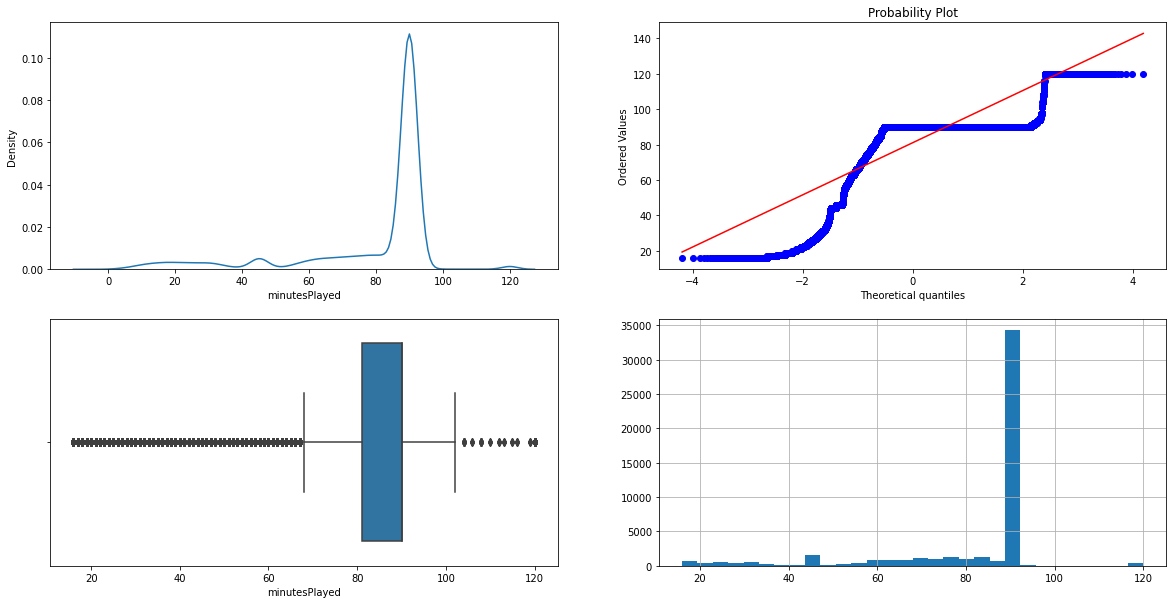

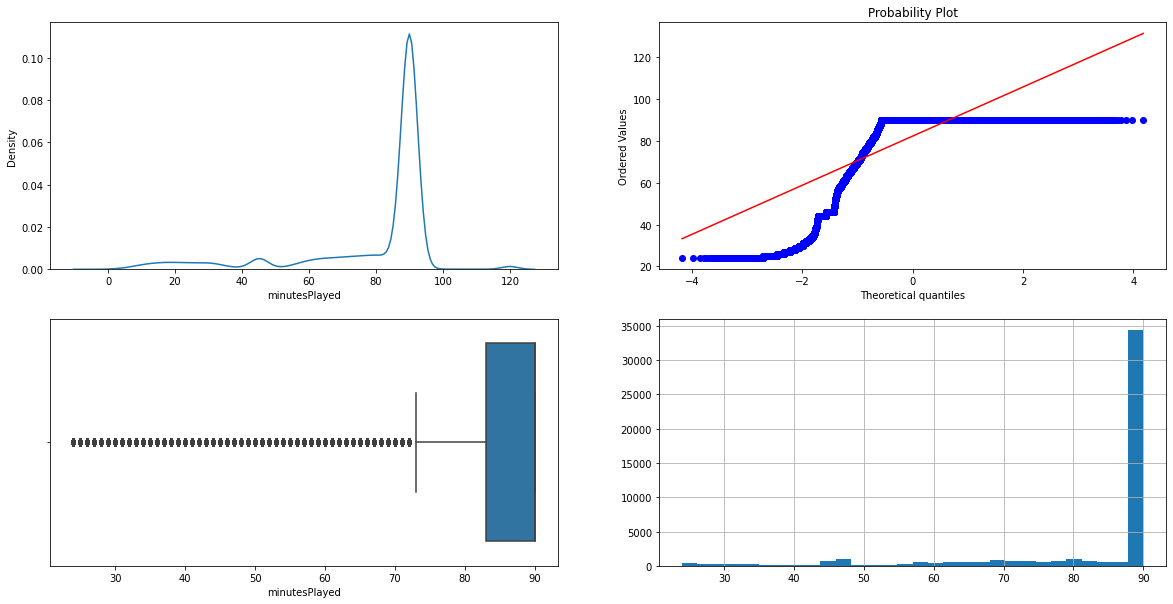

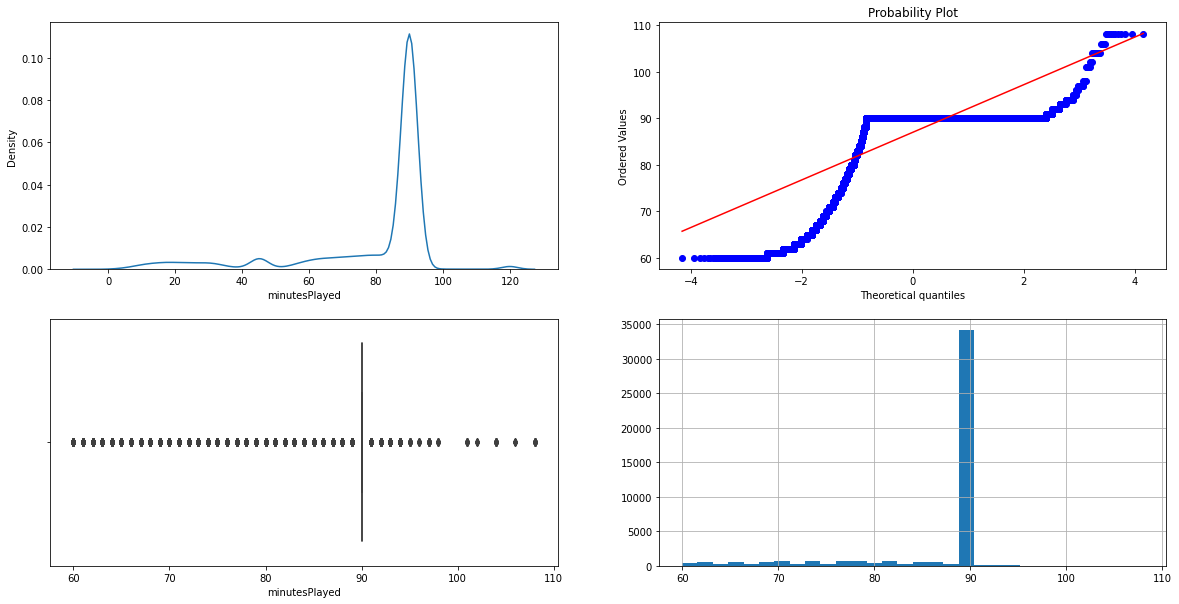

In [32]:
for key, value in outlierBoundaryType.items():
 col = 'minutesPlayed'
 lower_boundary, upper_boundary = get_outlier_boundaries(data, col, value)
 outliers_temp = np.where(data[col] > upper_boundary, True, np.where(data[col] < lower_boundary, True, False))
 data_trimmed = data.loc[~(outliers_temp), ]
 diagnostic_plots(data_trimmed, col)

Обработка нестандартного признака

In [33]:
data2 = pd.read_csv('football.csv', sep = ",")
data2.head()



,competition,date,match,team,pos,pos_role,player,rater,is_human,original_rating,...,betweenness_centrality,closeness_centrality,flow_centrality,flow_success,betweenness2goals,win,lost,is_home_team,minutesPlayed,game_duration
0,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,Kicker,1,3.50,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90,90
1,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,WhoScored,0,6.56,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90,90
2,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,SofaScore,0,6.70,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90,90
3,Euro 2016,10/06/2016,"France - Romania, 2 - 1",France,Sub,Sub,Anthony Martial,WhoScored,0,6.19,...,0.051556,0.524845,0.041096,0.166667,0.0,1,0,1,13,90
4,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,MF,DMC,Mihai Pintilii,Kicker,1,3.50,...,0.333284,0.710084,0.347826,0.675075,0.0,0,1,0,90,90


In [34]:
imputer = SimpleImputer(strategy="mean")
data2[['original_rating']] = imputer.fit_transform(data2[['original_rating']])
data2[['minutesPlayed']] = imputer.fit_transform(data2[['minutesPlayed']])
data2[['game_duration']] = imputer.fit_transform(data2[['game_duration']])
data2 = data2.drop(columns=['assists'])
data2.head()

,competition,date,match,team,pos,pos_role,player,rater,is_human,original_rating,...,betweenness_centrality,closeness_centrality,flow_centrality,flow_success,betweenness2goals,win,lost,is_home_team,minutesPlayed,game_duration
0,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,Kicker,1,3.50,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90.0,90.0
1,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,WhoScored,0,6.56,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90.0,90.0
2,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,SofaScore,0,6.70,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90.0,90.0
3,Euro 2016,10/06/2016,"France - Romania, 2 - 1",France,Sub,Sub,Anthony Martial,WhoScored,0,6.19,...,0.051556,0.524845,0.041096,0.166667,0.0,1,0,1,13.0,90.0
4,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,MF,DMC,Mihai Pintilii,Kicker,1,3.50,...,0.333284,0.710084,0.347826,0.675075,0.0,0,1,0,90.0,90.0


In [35]:

day = []
month = []
year = []
for item in data2['date']:
 year.append(int(item.split('/')[0]))
 month.append(int(item.split('/')[1]))
 day.append(int(item.split('/')[2]))
data2.insert(3, 'day1', day, allow_duplicates=False)
data2.insert(2, 'month1', month, allow_duplicates=False)
data2.insert(1, 'year1', year, allow_duplicates=False)

data2 = data2.drop(columns='date')
data2.head()


,competition,year1,month1,match,day1,team,pos,pos_role,player,rater,...,betweenness_centrality,closeness_centrality,flow_centrality,flow_success,betweenness2goals,win,lost,is_home_team,minutesPlayed,game_duration
0,Euro 2016,10,6,"France - Romania, 2 - 1",2016,Romania,DF,DC,Dragos Grigore,Kicker,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90.0,90.0
1,Euro 2016,10,6,"France - Romania, 2 - 1",2016,Romania,DF,DC,Dragos Grigore,WhoScored,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90.0,90.0
2,Euro 2016,10,6,"France - Romania, 2 - 1",2016,Romania,DF,DC,Dragos Grigore,SofaScore,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90.0,90.0
3,Euro 2016,10,6,"France - Romania, 2 - 1",2016,France,Sub,Sub,Anthony Martial,WhoScored,...,0.051556,0.524845,0.041096,0.166667,0.0,1,0,1,13.0,90.0
4,Euro 2016,10,6,"France - Romania, 2 - 1",2016,Romania,MF,DMC,Mihai Pintilii,Kicker,...,0.333284,0.710084,0.347826,0.675075,0.0,0,1,0,90.0,90.0


Отбор признаков по корреляции


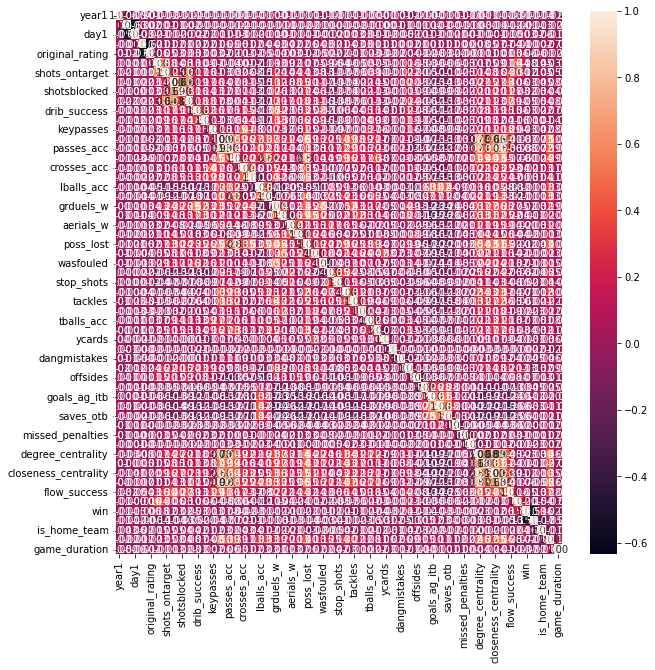

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data2.corr(method='pearson'), annot=True, fmt='.2f')


In [44]:
for row in data2.corr():
 if data2.corr()[row]['win'] > 0.1:
  print(row, data2.corr()[row]['win'])

goals 0.17785703004679385
shots_ontarget 0.11863457021185247
countattack 0.13311069670670414
flow_success 0.14535865087257765
betweenness2goals 0.20350335177411552
win 1.0
is_home_team 0.15700696220358323
